In [1]:
# Imports
import pickle
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches
from copy import deepcopy
import plotly.graph_objects as go

import sys
module_path = 'code' 
if module_path not in sys.path:
    sys.path.append(module_path)

# Markus's code
from MM_Plot_Utils import plot, hist
from MM_Maze_Utils import *
from MM_Traj_Utils import *

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from utils import convert_episodes_to_traj_class
import evaluation_metrics as em
import parameters as p
import utils
import glob
from collections import Counter
import joblib

In [3]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams["font.size"] = 18

In [4]:
figpath = '/Users/us3519/mouse-maze/figs/paper figs/figure_results_rewarded'

In [5]:
# Calculating KL-divergence between learned state-action probability distribution vs estimated from the data.

In [6]:
from scipy.stats import entropy
from scipy.special import kl_div, rel_entr, entr
from scipy.stats import ttest_ind, ttest_rel

In [23]:
model_colors = {
    'RewAnimals': 'r',
    'TeAltOptions': 'g',
    'BiasedWalk4': 'y',
    'RandomWalk': 'b',
    'Optimal': 'k:',
    'Uncertainty': 'tab:pink',
}

labels = {
    'RewAnimals':   'RewAnimals',
    'TeAltOptions': '$\epsilon$$z$-Greedy',
    'BiasedWalk4':  'Biased Walk',
    'Uncertainty':  'Uncertainty',
    'RandomWalk':   'random',
    'Optimal':      'optimal',
}

In [9]:
def load(model_name):
    if model_name == 'RewAnimals':
        tfs = [LoadTrajFromPath(f'../outdata/{_}-tf') for _ in p.RewNames]
        return tfs
    
#     if model_name == 'MarkovChain':
#         tfs = [LoadTrajFromPath(f'../../Rosenberg-2021-Repository/outdata/{_}-MarkovSim-tf') for _ in UnrewNamesSub]
#         return tfs

    tfs = []
    for f in glob.glob(f'/Users/us3519/mouse-maze/figs/may28/{model_name}/MAX_LENGTH=500000/**/episodes_*.pkl'):
        s = joblib.load(f)
        tf = convert_episodes_to_traj_class(s["episodes_positions"], s["episodes_states"])
        tfs.append(tf)
    return tfs

In [10]:
def get_prob_dist(samples_count_dict, support, alpha=1e-6):
    counts = Counter(samples_count_dict)
    probs = np.array([counts[a] + alpha for a in support], dtype=np.float64)
    probs /= probs.sum()
    return probs

In [11]:
var = False
tju = True  # masking endnodes make sense, as there is only one action there

entr_animal_tes = {}
entr_animal_bws = {}
entr_animal_uncs = {}

for par in range(1, 7):
    print(f"=============== At depth={par} ==================")
    entr_animal_tes[par] = []
    entr_animal_bws[par] = []
    entr_animal_uncs[par] = []

    biasedwalk_tf = load('BiasedWalk4')[0]
    hi_bw, _, _, pt_dict_bw = em.markov_fit_pooling_pr(biasedwalk_tf, re=False, tju=tju, var=var, par=par)
#     print('Biased Walk:', hi_bw, len(pt_dict_bw))

    tealtopt_tf = load('TeAltOptions')[0]
    hi_te, _, _, pt_dict_tealtopt = em.markov_fit_pooling_pr(tealtopt_tf, re=False, tju=tju, var=var, par=par)
    
    unc_tf = load('Uncertainty')[0]
    hi_unc, _, _, pt_dict_unc = em.markov_fit_pooling_pr(unc_tf, re=False, tju=tju, var=var, par=par)
#     print('Uncertainty:', hi_unc, len(pt_dict_unc))

    for nickname in p.UnrewNamesSub:
        tf = LoadTrajFromPath(f'../outdata/{nickname}-tf')
        hi_animal, _, _, pt_dict_animal = em.markov_fit_pooling_pr(tf, re=False, tju=tju, var=var, par=par)
#         print(f'{nickname}:', hi_animal, len(pt_dict_animal))

        support = sorted(set(pt_dict_animal) | set(pt_dict_tealtopt) | set(pt_dict_bw) | set(pt_dict_unc)) # create shared support
#         print(support[:100])
        print("len(support):", len(support))

        pt_animal = get_prob_dist(pt_dict_animal, support)
        pt_te = get_prob_dist(pt_dict_tealtopt, support)
        pt_bw = get_prob_dist(pt_dict_bw, support)
        pt_unc = get_prob_dist(pt_dict_unc, support)

        entr_animal_te = np.sum(rel_entr(pt_animal, pt_te))
        entr_animal_bw = np.sum(rel_entr(pt_animal, pt_bw))
        entr_animal_unc = np.sum(rel_entr(pt_animal, pt_unc))

#         print('te:', entr_animal_te)
#         print('bw:', entr_animal_bw)

        entr_animal_tes[par].append(entr_animal_te)
        entr_animal_bws[par].append(entr_animal_bw)
        entr_animal_uncs[par].append(entr_animal_unc)
#         print()

=============== At depth=1 ==================
len(support): 33
len(support): 33
len(support): 33
len(support): 33
len(support): 33
len(support): 33
len(support): 33
len(support): 33
len(support): 33
=============== At depth=2 ==================
len(support): 96
len(support): 96
len(support): 96
len(support): 96
len(support): 96
len(support): 96
len(support): 96
len(support): 96
len(support): 96
=============== At depth=3 ==================
len(support): 258
len(support): 258
len(support): 258
len(support): 258
len(support): 258
len(support): 258
len(support): 258
len(support): 258
len(support): 258
=============== At depth=4 ==================
len(support): 714
len(support): 714
len(support): 714
len(support): 714
len(support): 714
len(support): 714
len(support): 714
len(support): 714
len(support): 714
=============== At depth=5 ==================
len(support): 1920
len(support): 1920
len(support): 1920
len(support): 1920
len(support): 1920
len(support): 1920
len(support): 1920
len(sup

depth 1
t-statistic: 16.159939808220653
p-value: 2.160286765785119e-07
depth 2
t-statistic: -10.623665083993815
p-value: 5.393744731322946e-06
depth 3
t-statistic: -7.109750654844916
p-value: 0.00010101605132377563
depth 4
t-statistic: -1.8342693507437233
p-value: 0.10395470805194869
depth 5
t-statistic: 8.331434286892344
p-value: 3.25656180894523e-05
depth 6
t-statistic: 24.450024468324546
p-value: 8.35982853528109e-09


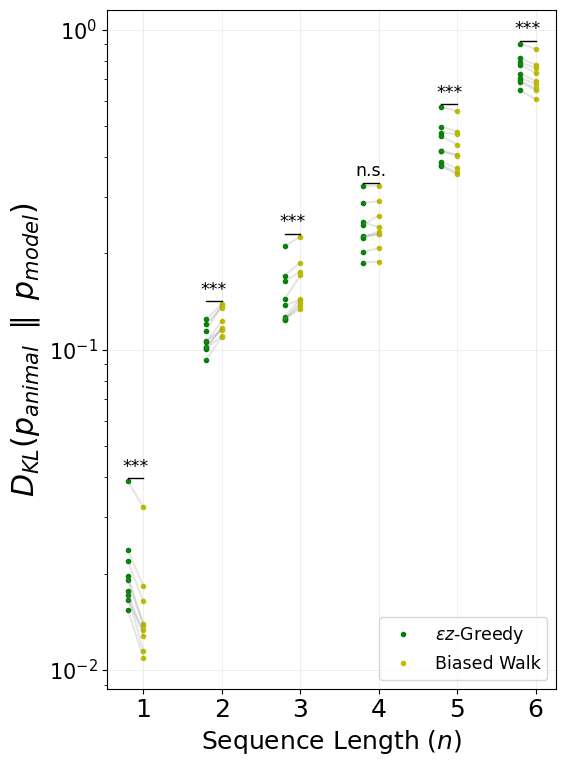

In [24]:
def get_stars(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'n.s.'

def plot_kl():
    
    plt.figure(figsize=(6, 8))

    xticks = []
    for depth in entr_animal_tes:
#         if depth > 5:
#             continue

        t_stat, p_value = ttest_rel(entr_animal_tes[depth], entr_animal_bws[depth])
        print("depth", depth)
        print("t-statistic:", t_stat)
        print("p-value:", p_value)
        stars = get_stars(p_value)
        
        n = len(entr_animal_tes[depth])
        x1 = depth-0.2
        x2 = depth+0.
        x3 = depth+0.2
        jitter0 = np.zeros(n)
        jitter1 = np.random.uniform(-0.02, 0.02, size=n)

        plt.plot(x1 + jitter0, entr_animal_tes[depth], f'{model_colors["TeAltOptions"]}', marker='.', linestyle='None', label=labels['TeAltOptions'] if depth == 1 else '')
        plt.plot(x2 + jitter0, entr_animal_bws[depth], f'{model_colors["BiasedWalk4"]}', marker='.', linestyle='None', label=labels['BiasedWalk4'] if depth == 1 else '')
#         plt.plot(x3 + jitter0, entr_animal_uncs[depth], f'{model_colors["Uncertainty"]}', marker='.', linestyle='None', label='Uncertainty' if depth == 1 else '')

        for i in range(len(entr_animal_tes[depth])):
            plt.plot([x1, x2], [entr_animal_tes[depth][i], entr_animal_bws[depth][i]], color='gray', alpha=0.2)

        # Add p-value line and stars
        y_max = max(max(entr_animal_tes[depth]), max(entr_animal_bws[depth]))
        y_line = y_max + 0.02 * y_max
        plt.plot([x1, x2], [y_line, y_line], color='black', linewidth=1)
        plt.text((x1+x2)/2, y_line + 0.02 * y_max, stars, ha='center', va='bottom', fontsize='x-small')
        xticks.append(depth)
    
    plt.ylabel('$D_{KL}$($p_{animal}$ $\parallel$ $p_{model})$', fontsize='large')
    plt.xlabel('Sequence Length ($n$)', fontsize='medium')
    plt.yticks(fontsize='small')
    plt.xticks(xticks)
    plt.legend(loc='lower right', fontsize='x-small')
    plt.yscale('log')

#     plt.margins(y=0.1)
    plt.tight_layout()
    plt.grid(alpha=0.2)
    plt.savefig(f'{figpath}/kl_var={var}_tju={tju}_all.pdf', dpi=300, transparent=True, bbox_inches='tight')
    plt.show()
    return


plot_kl()